In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from kan import KANLinear  # Assuming KANLinear is imported from the appropriate module

class FeaturePreprocessor(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, embed_dim):
        super().__init__()
        self.node_encoder = nn.Sequential(
            KANLinear(node_feat_dim, embed_dim, grid_size=5, spline_order=3),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            KANLinear(embed_dim, embed_dim, grid_size=5, spline_order=3)
        )
        
        self.edge_encoder = nn.Sequential(
            KANLinear(edge_feat_dim, embed_dim, grid_size=5, spline_order=3),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            KANLinear(embed_dim, embed_dim, grid_size=5, spline_order=3)
        )

    def forward(self, node_feat, real_edge_attrs):
        node_embed = self.node_encoder(node_feat.squeeze(0)).unsqueeze(0)  # [1, N, D]
        edge_embed = self.edge_encoder(real_edge_attrs.squeeze(0)).unsqueeze(0)  # [1, E, D]
        return node_embed, edge_embed

class VirtualEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = KANLinear(embed_dim, 3*embed_dim, grid_size=5, spline_order=3)
        self.edge_weight_net = nn.Sequential(
            KANLinear(2*embed_dim, embed_dim, grid_size=5, spline_order=3),
            nn.GELU(),
            KANLinear(embed_dim, 1, grid_size=5, spline_order=3)
        )
        
        self.ffn = nn.Sequential(
            KANLinear(embed_dim, 2*embed_dim, grid_size=5, spline_order=3),
            nn.GELU(),
            KANLinear(2*embed_dim, embed_dim, grid_size=5, spline_order=3)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, virtual_edge_index):
        x = x.squeeze(0)  # [N, D]
        src, dst = virtual_edge_index
        
        # Project to Q/K/V
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(-1, self.num_heads, self.head_dim), qkv)
        
        # Compute edge weights (Eq.7)
        edge_feat = torch.cat([x[src], x[dst]], dim=-1)
        beta = self.edge_weight_net(edge_feat)  # [E, 1]
        
        # Compute attention scores
        attn_scores = (q[src] * k[dst]).sum(-1) / self.head_dim**0.5  # [E, H]
        attn_scores = attn_scores + beta
        attn = F.softmax(attn_scores, dim=0)  # [E, H]
        
        # Aggregate messages
        messages = (attn.unsqueeze(-1) * v[dst])  # [E, H, d]
        messages = messages.view(-1, self.embed_dim)  # [E, D]
        out = torch.zeros_like(x)
        out.index_add_(0, src, messages)  # [N, D]
        
        # FFN + residual
        out = self.norm(x + self.ffn(out)).unsqueeze(0)  # [1, N, D]
        return out

class RealEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, edge_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = KANLinear(embed_dim, 3*embed_dim, grid_size=5, spline_order=3)
        self.edge_proj = KANLinear(edge_dim, num_heads, grid_size=5, spline_order=3)
        
        self.ffn = nn.Sequential(
            KANLinear(embed_dim, 2*embed_dim, grid_size=5, spline_order=3),
            nn.GELU(),
            KANLinear(2*embed_dim, embed_dim, grid_size=5, spline_order=3)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, real_edge_index, edge_attrs):
        x = x.squeeze(0)  # [N, D]
        src, dst = real_edge_index
        
        # Project to Q/K/V
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(-1, self.num_heads, self.head_dim), qkv)
        
        # Edge projections (sum over P in Eq.9)
        edge_scores = self.edge_proj(edge_attrs.squeeze(0))  # [E, H]
        
        # Compute attention scores
        attn_scores = (q[src] * k[dst]).sum(-1) / self.head_dim**0.5  # [E, H]
        attn_scores = attn_scores + edge_scores
        attn = F.softmax(attn_scores, dim=0)  # [E, H]
        
        # Aggregate messages
        messages = (attn.unsqueeze(-1) * v[dst])  # [E, H, d]
        messages = messages.view(-1, self.embed_dim)  # [E, D]
        out = torch.zeros_like(x)
        out.index_add_(0, src, messages)  # [N, D]
        
        # FFN + residual
        out = self.norm(x + self.ffn(out)).unsqueeze(0)  # [1, N, D]
        return out

class HetGAT(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, embed_dim=64, num_heads=8):
        super().__init__()
        self.preprocessor = FeaturePreprocessor(node_feat_dim, edge_feat_dim, embed_dim)
        
        self.v_encoders = nn.ModuleList([
            VirtualEncoderLayer(embed_dim, num_heads)
            for _ in range(2)
        ])
        
        self.r_encoders = nn.ModuleList([
            RealEncoderLayer(embed_dim, num_heads, edge_dim=embed_dim)
            for _ in range(2)
        ])
        
        self.predictor = nn.Sequential(
            KANLinear(2*embed_dim + edge_feat_dim, embed_dim, grid_size=5, spline_order=3),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            KANLinear(embed_dim, 1, grid_size=5, spline_order=3)
        )

    def forward(self, node_feat, real_edge_index, virtual_edge_index, real_edge_attrs):
        # Preprocess features (batch=1)
        x, edge_emb = self.preprocessor(node_feat, real_edge_attrs)
        
        # Virtual encoding
        for encoder in self.v_encoders:
            x = encoder(x, virtual_edge_index)
        
        # Real encoding
        for encoder in self.r_encoders:
            x = encoder(x, real_edge_index, edge_emb)
        
        # Edge prediction
        src, dst = real_edge_index
        h_src = x.squeeze(0)[src]  # [E, D]
        h_dst = x.squeeze(0)[dst]  # [E, D]
        edge_feat = torch.cat([h_src, h_dst, real_edge_attrs.squeeze(0)], dim=-1)
        alpha = self.predictor(edge_feat).squeeze(-1)  # [1, E]
        return alpha

In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from utility import CustomHeteroGraphDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from utility import prepare_scalers
from sklearn.preprocessing import MinMaxScaler

src = "data/data_sioux.csv"

df = pd.read_csv(src)

indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

node_scaler, edge_scaler, y_scaler = prepare_scalers(src, train_indices, n_nodes=24, scaler_type=MinMaxScaler)

train_dataset = CustomHeteroGraphDataset(src, train_indices, node_scaler, edge_scaler, y_scaler, 24)
test_dataset = CustomHeteroGraphDataset(src, test_indices, node_scaler, edge_scaler, y_scaler, 24)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda batch: Batch.from_data_list(batch))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda batch: Batch.from_data_list(batch))


c:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HetGAT(24, 2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
mae_f = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()

train_losses = []
test_losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    total_train_loss = 0
    total_train_batches = 0

    for i, data in enumerate(train_loader): 
        data = data.to(device)
        optimizer.zero_grad()
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        loss = loss_fn(pred_f, data['real'].y)

        if i == 0:
            print("Sample predictions:")
            print("True flow:", data['real'].y[:5])
            print("Pred flow:", pred_f[:5])

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_batches += 1

    avg_train_loss = total_train_loss / total_train_batches
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch}, avg train Loss: {avg_train_loss:.4f}')

    model.eval()
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
            pred_f = pred_alpha * data['real'].edge_attr[:, 1]
            batch_loss = loss_fn(pred_f, data['real'].y)
            total_loss += batch_loss.item()
            total_batches += 1

    test_loss = total_loss / total_batches
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Test MSE: {test_loss:.4f}')



  0%|          | 0/40 [00:00<?, ?it/s]

Sample predictions:
True flow: tensor([0.1807, 0.2316, 0.1000, 0.2068, 0.2889], device='cuda:0')
Pred flow: tensor([-0.1225, -0.1985, -0.3724, -0.0317, -0.5345], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 1, avg train Loss: 0.0027


  2%|▎         | 1/40 [10:25<6:46:52, 625.95s/it]

Epoch 1, Test MSE: 0.0016
Sample predictions:
True flow: tensor([0.0746, 0.3073, 0.1662, 0.0347, 0.1899], device='cuda:0')
Pred flow: tensor([0.0934, 0.2796, 0.1312, 0.0636, 0.2675], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 2, avg train Loss: 0.0015


  5%|▌         | 2/40 [20:33<6:29:44, 615.39s/it]

Epoch 2, Test MSE: 0.0013
Sample predictions:
True flow: tensor([0.0797, 0.2576, 0.1623, 0.0586, 0.2040], device='cuda:0')
Pred flow: tensor([0.1004, 0.2617, 0.1600, 0.0709, 0.2786], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 3, avg train Loss: 0.0012


  8%|▊         | 3/40 [30:41<6:17:12, 611.69s/it]

Epoch 3, Test MSE: 0.0011
Sample predictions:
True flow: tensor([0.1009, 0.2797, 0.1676, 0.0815, 0.2372], device='cuda:0')
Pred flow: tensor([0.1042, 0.2492, 0.1701, 0.0863, 0.2553], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 4, avg train Loss: 0.0010


 10%|█         | 4/40 [40:33<6:02:17, 603.83s/it]

Epoch 4, Test MSE: 0.0009
Sample predictions:
True flow: tensor([0.1124, 0.2178, 0.0860, 0.1028, 0.2261], device='cuda:0')
Pred flow: tensor([0.1448, 0.2612, 0.1092, 0.1154, 0.2599], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 5, avg train Loss: 0.0009


 12%|█▎        | 5/40 [50:19<5:48:32, 597.49s/it]

Epoch 5, Test MSE: 0.0009
Sample predictions:
True flow: tensor([0.1186, 0.2971, 0.1324, 0.0949, 0.2400], device='cuda:0')
Pred flow: tensor([0.1524, 0.2697, 0.1107, 0.1211, 0.2440], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 6, avg train Loss: 0.0008


 15%|█▌        | 6/40 [1:00:12<5:37:40, 595.89s/it]

Epoch 6, Test MSE: 0.0008
Sample predictions:
True flow: tensor([0.1914, 0.2807, 0.1713, 0.1599, 0.3163], device='cuda:0')
Pred flow: tensor([0.1957, 0.3044, 0.1638, 0.1683, 0.3085], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 7, avg train Loss: 0.0007


 18%|█▊        | 7/40 [1:09:50<5:24:36, 590.19s/it]

Epoch 7, Test MSE: 0.0010
Sample predictions:
True flow: tensor([0.1154, 0.2628, 0.1271, 0.0804, 0.2317], device='cuda:0')
Pred flow: tensor([0.0910, 0.2310, 0.0987, 0.0797, 0.2411], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 8, avg train Loss: 0.0007


 20%|██        | 8/40 [1:19:20<5:11:24, 583.90s/it]

Epoch 8, Test MSE: 0.0007
Sample predictions:
True flow: tensor([0.1611, 0.2872, 0.1587, 0.1587, 0.2970], device='cuda:0')
Pred flow: tensor([0.1588, 0.2772, 0.1623, 0.1360, 0.2654], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 9, avg train Loss: 0.0007


 22%|██▎       | 9/40 [1:28:48<4:59:06, 578.92s/it]

Epoch 9, Test MSE: 0.0007
Sample predictions:
True flow: tensor([0.1723, 0.2375, 0.1310, 0.1654, 0.2874], device='cuda:0')
Pred flow: tensor([0.1666, 0.2717, 0.1405, 0.1543, 0.3033], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 10, avg train Loss: 0.0006


 25%|██▌       | 10/40 [1:38:17<4:47:51, 575.71s/it]

Epoch 10, Test MSE: 0.0007
Sample predictions:
True flow: tensor([0.1313, 0.2778, 0.1597, 0.1086, 0.2997], device='cuda:0')
Pred flow: tensor([0.1068, 0.2914, 0.1725, 0.0899, 0.2685], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 11, avg train Loss: 0.0006


 28%|██▊       | 11/40 [1:47:53<4:38:14, 575.68s/it]

Epoch 11, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.1271, 0.2769, 0.1518, 0.0741, 0.2708], device='cuda:0')
Pred flow: tensor([0.0863, 0.2644, 0.1773, 0.0678, 0.2666], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 12, avg train Loss: 0.0006


 30%|███       | 12/40 [1:57:35<4:29:36, 577.73s/it]

Epoch 12, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.1589, 0.2687, 0.1145, 0.1339, 0.2930], device='cuda:0')
Pred flow: tensor([0.1678, 0.2713, 0.1292, 0.1336, 0.3085], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 13, avg train Loss: 0.0006


 32%|███▎      | 13/40 [2:06:42<4:15:50, 568.53s/it]

Epoch 13, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.1176, 0.2779, 0.1307, 0.1023, 0.2380], device='cuda:0')
Pred flow: tensor([0.1181, 0.2884, 0.1402, 0.0937, 0.2367], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 14, avg train Loss: 0.0005


 35%|███▌      | 14/40 [2:15:48<4:03:20, 561.57s/it]

Epoch 14, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.2050, 0.3177, 0.2267, 0.1939, 0.3290], device='cuda:0')
Pred flow: tensor([0.1829, 0.2828, 0.2185, 0.1626, 0.2745], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 15, avg train Loss: 0.0005


 38%|███▊      | 15/40 [2:24:54<3:52:01, 556.85s/it]

Epoch 15, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.0990, 0.3366, 0.2174, 0.0573, 0.2205], device='cuda:0')
Pred flow: tensor([0.0947, 0.3077, 0.1978, 0.0759, 0.2044], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 16, avg train Loss: 0.0005


 40%|████      | 16/40 [2:34:00<3:41:31, 553.81s/it]

Epoch 16, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1908, 0.2437, 0.1393, 0.1745, 0.2928], device='cuda:0')
Pred flow: tensor([0.1710, 0.2248, 0.1440, 0.1555, 0.2729], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 17, avg train Loss: 0.0005


 42%|████▎     | 17/40 [2:43:07<3:31:27, 551.62s/it]

Epoch 17, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1698, 0.3244, 0.1293, 0.1487, 0.3052], device='cuda:0')
Pred flow: tensor([0.1658, 0.3461, 0.1570, 0.1322, 0.3232], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 18, avg train Loss: 0.0005


 45%|████▌     | 18/40 [2:52:14<3:21:45, 550.23s/it]

Epoch 18, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1097, 0.2521, 0.1345, 0.0897, 0.2380], device='cuda:0')
Pred flow: tensor([0.1065, 0.2645, 0.1277, 0.0951, 0.2423], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 19, avg train Loss: 0.0005


 48%|████▊     | 19/40 [3:01:20<3:12:07, 548.91s/it]

Epoch 19, Test MSE: 0.0007
Sample predictions:
True flow: tensor([0.1140, 0.2779, 0.1587, 0.1054, 0.2410], device='cuda:0')
Pred flow: tensor([0.1306, 0.2454, 0.1123, 0.1071, 0.2665], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 20, avg train Loss: 0.0005


 50%|█████     | 20/40 [3:10:26<3:02:40, 548.03s/it]

Epoch 20, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.1045, 0.3332, 0.2152, 0.0874, 0.2277], device='cuda:0')
Pred flow: tensor([0.1455, 0.3452, 0.2248, 0.0989, 0.2697], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 21, avg train Loss: 0.0004


 52%|█████▎    | 21/40 [3:19:33<2:53:25, 547.66s/it]

Epoch 21, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1807, 0.2318, 0.0978, 0.1523, 0.3098], device='cuda:0')
Pred flow: tensor([0.1862, 0.2340, 0.0822, 0.1473, 0.3145], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 22, avg train Loss: 0.0004


 55%|█████▌    | 22/40 [3:28:39<2:44:10, 547.25s/it]

Epoch 22, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.0849, 0.2466, 0.1060, 0.0612, 0.2150], device='cuda:0')
Pred flow: tensor([0.0936, 0.2246, 0.1001, 0.0752, 0.2309], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 23, avg train Loss: 0.0004


 57%|█████▊    | 23/40 [3:37:43<2:34:44, 546.17s/it]

Epoch 23, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.2053, 0.2859, 0.1729, 0.1614, 0.3080], device='cuda:0')
Pred flow: tensor([0.1734, 0.2720, 0.1543, 0.1490, 0.2990], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 24, avg train Loss: 0.0004


 60%|██████    | 24/40 [3:46:46<2:25:26, 545.38s/it]

Epoch 24, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1300, 0.3010, 0.1550, 0.0966, 0.2622], device='cuda:0')
Pred flow: tensor([0.0959, 0.3043, 0.1391, 0.0970, 0.2167], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 25, avg train Loss: 0.0004


 62%|██████▎   | 25/40 [3:55:47<2:16:00, 544.03s/it]

Epoch 25, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1352, 0.1921, 0.0929, 0.1123, 0.2497], device='cuda:0')
Pred flow: tensor([0.1231, 0.2188, 0.1207, 0.1171, 0.2624], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 26, avg train Loss: 0.0004


 65%|██████▌   | 26/40 [4:04:51<2:06:58, 544.19s/it]

Epoch 26, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1153, 0.2208, 0.0974, 0.0820, 0.2570], device='cuda:0')
Pred flow: tensor([0.1299, 0.2264, 0.0966, 0.0894, 0.2969], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 27, avg train Loss: 0.0004


 68%|██████▊   | 27/40 [4:13:53<1:57:43, 543.36s/it]

Epoch 27, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1632, 0.2586, 0.1274, 0.1592, 0.2396], device='cuda:0')
Pred flow: tensor([0.1718, 0.2769, 0.1362, 0.1616, 0.2640], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 28, avg train Loss: 0.0004


 70%|███████   | 28/40 [4:22:57<1:48:43, 543.60s/it]

Epoch 28, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.0746, 0.3073, 0.1662, 0.0347, 0.1899], device='cuda:0')
Pred flow: tensor([0.0817, 0.2883, 0.1518, 0.0603, 0.1994], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 29, avg train Loss: 0.0004


 72%|███████▎  | 29/40 [4:32:02<1:39:43, 543.94s/it]

Epoch 29, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1056, 0.3006, 0.1711, 0.0938, 0.2261], device='cuda:0')
Pred flow: tensor([0.1057, 0.3003, 0.1704, 0.0918, 0.2461], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 30, avg train Loss: 0.0004


 75%|███████▌  | 30/40 [4:41:06<1:30:40, 544.02s/it]

Epoch 30, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1184, 0.2687, 0.1507, 0.1034, 0.2296], device='cuda:0')
Pred flow: tensor([0.1175, 0.2918, 0.1665, 0.1052, 0.2396], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 31, avg train Loss: 0.0004


 78%|███████▊  | 31/40 [4:50:11<1:21:38, 544.31s/it]

Epoch 31, Test MSE: 0.0004
Sample predictions:
True flow: tensor([0.1302, 0.2875, 0.1681, 0.0914, 0.2754], device='cuda:0')
Pred flow: tensor([0.1264, 0.3096, 0.1738, 0.0872, 0.2715], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 32, avg train Loss: 0.0004


 80%|████████  | 32/40 [4:59:13<1:12:29, 543.66s/it]

Epoch 32, Test MSE: 0.0006
Sample predictions:
True flow: tensor([0.1071, 0.3269, 0.2066, 0.0737, 0.2610], device='cuda:0')
Pred flow: tensor([0.0969, 0.3076, 0.1974, 0.0714, 0.2317], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 33, avg train Loss: 0.0004


 82%|████████▎ | 33/40 [5:08:16<1:03:23, 543.31s/it]

Epoch 33, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1819, 0.2278, 0.1125, 0.1698, 0.3260], device='cuda:0')
Pred flow: tensor([0.1685, 0.2407, 0.1043, 0.1472, 0.2888], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 34, avg train Loss: 0.0004


 85%|████████▌ | 34/40 [5:17:20<54:22, 543.73s/it]  

Epoch 34, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1066, 0.2381, 0.0808, 0.0996, 0.2850], device='cuda:0')
Pred flow: tensor([0.0916, 0.2504, 0.1238, 0.0950, 0.2417], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 35, avg train Loss: 0.0004


 88%|████████▊ | 35/40 [5:26:25<45:20, 544.14s/it]

Epoch 35, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1490, 0.2065, 0.1034, 0.1194, 0.2425], device='cuda:0')
Pred flow: tensor([0.1470, 0.2180, 0.1084, 0.1115, 0.2376], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 36, avg train Loss: 0.0004


 90%|█████████ | 36/40 [5:35:28<36:15, 543.81s/it]

Epoch 36, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.1635, 0.2883, 0.1492, 0.1215, 0.3093], device='cuda:0')
Pred flow: tensor([0.1373, 0.2633, 0.1266, 0.1186, 0.3025], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 37, avg train Loss: 0.0004


 92%|█████████▎| 37/40 [5:44:32<27:11, 543.85s/it]

Epoch 37, Test MSE: 0.0004
Sample predictions:
True flow: tensor([0.1247, 0.2379, 0.1533, 0.0953, 0.2106], device='cuda:0')
Pred flow: tensor([0.1240, 0.2663, 0.1739, 0.0903, 0.2239], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 38, avg train Loss: 0.0003


 95%|█████████▌| 38/40 [5:53:31<18:04, 542.27s/it]

Epoch 38, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.0990, 0.2409, 0.1184, 0.0727, 0.2049], device='cuda:0')
Pred flow: tensor([0.1091, 0.2278, 0.1306, 0.0892, 0.2217], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 39, avg train Loss: 0.0003


 98%|█████████▊| 39/40 [6:03:08<09:12, 552.76s/it]

Epoch 39, Test MSE: 0.0005
Sample predictions:
True flow: tensor([0.0955, 0.3186, 0.1960, 0.0923, 0.1934], device='cuda:0')
Pred flow: tensor([0.1086, 0.3125, 0.1792, 0.1109, 0.2106], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 40, avg train Loss: 0.0003


100%|██████████| 40/40 [6:12:00<00:00, 558.01s/it]

Epoch 40, Test MSE: 0.0004


In [13]:
import json

model = 'hgnn'

with open(f'loss/{model}_test_loss.json', "r") as f:
    test_losses = json.load(f)

with open(f'loss/{model}_train_loss.json', "r") as f:
    train_losses = json.load(f)

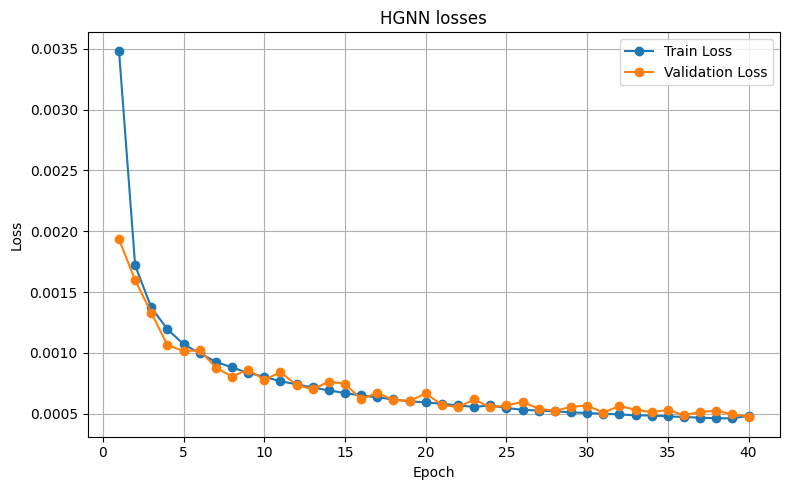

In [14]:

from matplotlib import pyplot as plt


epochs = range(1, len(train_losses) + 1)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, [loss for loss in test_losses], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HGNN losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

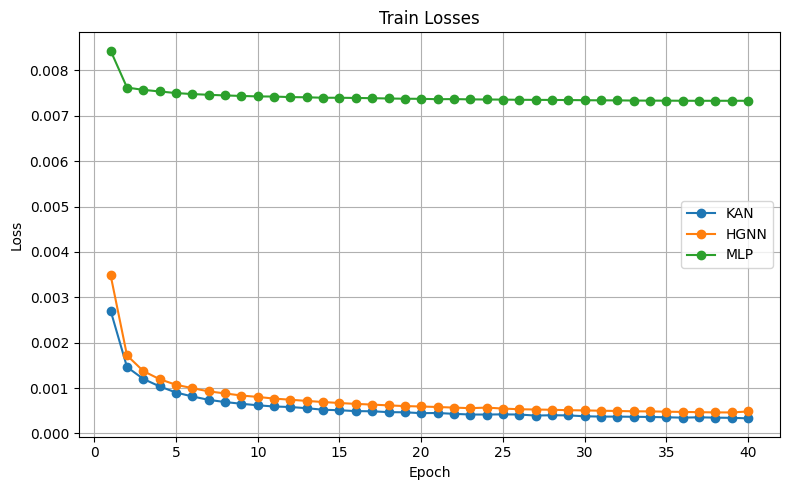

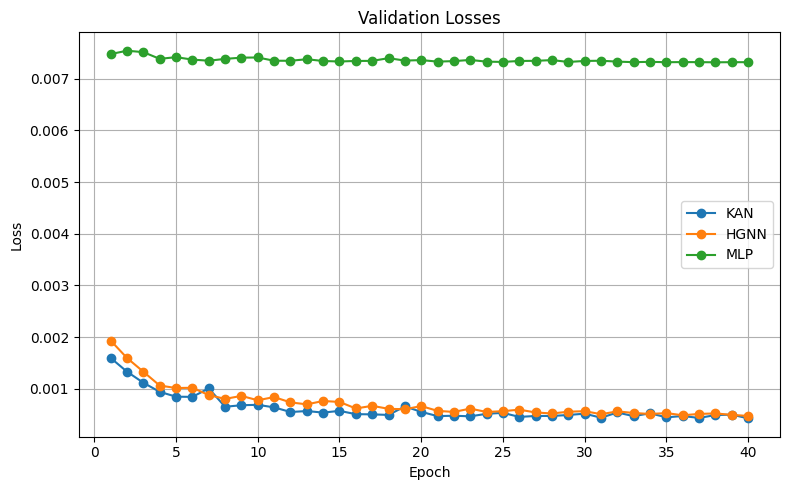

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


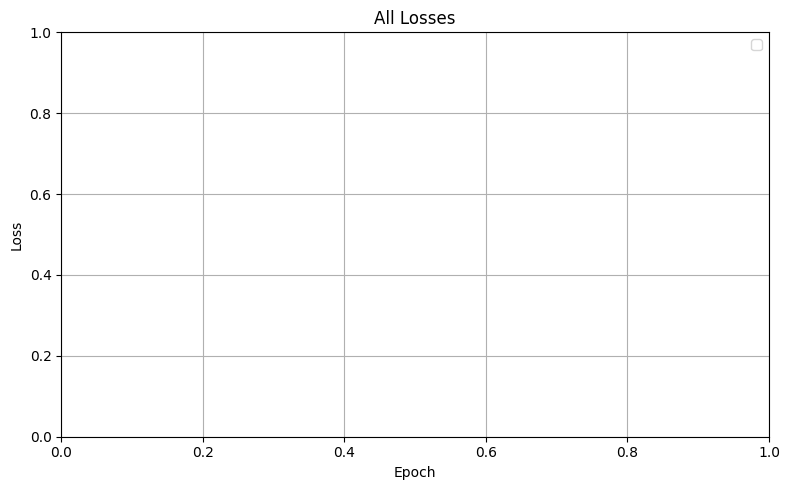

In [17]:
import json
import matplotlib.pyplot as plt
import os

LOSS_DIR = "loss"
models = ["kan", "hgnn", "mlp"]

def load_loss(model, loss_type):
    path = os.path.join(LOSS_DIR, f"{model}_{loss_type}.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

train_losses = {model: load_loss(model, "train_loss") for model in models}
test_losses = {model: load_loss(model, "test_loss") for model in models}
all_losses = {model: load_loss(model, "loss") for model in models}

def plot_losses(loss_dict, title):
    plt.figure(figsize=(8, 5))
    for model, loss in loss_dict.items():
        if loss is not None:
            epochs = list(range(1, len(loss) + 1))
            plt.plot(epochs, loss, label=model.upper(), marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(train_losses, "Train Losses")
plot_losses(test_losses, "Validation Losses")
plot_losses(all_losses, "All Losses")


In [20]:
import os


notebook_name = "kan"  # <-- измени на уникальное имя
print(train_losses)
# Создание папки, если её ещё нет
os.makedirs("loss", exist_ok=True)

# Сохраняем train_loss, test_loss и loss (если они существуют)
if 'train_losses' in globals():
    with open(f"loss/{notebook_name}_train_loss.json", "w") as f:
        json.dump(train_losses, f)

if 'test_losses' in globals():
    with open(f"loss/{notebook_name}_test_loss.json", "w") as f:
        json.dump(test_losses, f)

[0.0027020641396266177, 0.0014622733904303895, 0.001200004052630157, 0.0010351227946937564, 0.0009001938508091754, 0.0008139538810688139, 0.0007389396968632647, 0.0006901730473077025, 0.0006526254289033581, 0.0006188264933942129, 0.0005925046605246807, 0.0005811809364277419, 0.0005548759895171967, 0.0005210736768162536, 0.0005097431983357198, 0.0004909187312565856, 0.0004870788641828548, 0.00046826790587091004, 0.00046442466160538176, 0.0004456069489098425, 0.0004492576932429147, 0.0004304399805473754, 0.0004153743279388324, 0.00041526288060951587, 0.00041892713370977755, 0.00041507038067705934, 0.00039251411666171333, 0.0003999067895063893, 0.0003960770540080514, 0.0003772559641207142, 0.00036966403695998674, 0.00036957285278145513, 0.00036573974009131887, 0.0003618998730175885, 0.0003543180774322535, 0.0003467295274633235, 0.00035412895469159487, 0.00034654715910625985, 0.0003426802744981496, 0.0003313700591684003]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


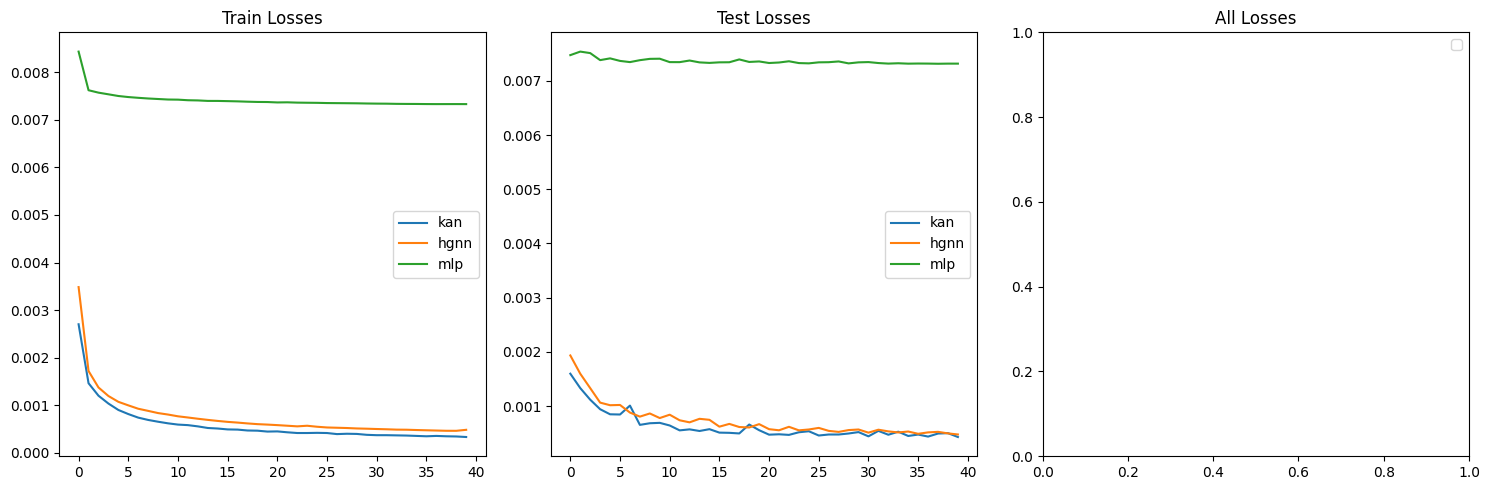

In [15]:
import json
import matplotlib.pyplot as plt
import os

LOSS_DIR = "loss"
models = ["kan", "hgnn", "mlp"]

def load_loss(model, loss_type):
    path = os.path.join(LOSS_DIR, f"{model}_{loss_type}.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

train_losses = {model: load_loss(model, "train_loss") for model in models}
test_losses = {model: load_loss(model, "test_loss") for model in models}
all_losses = {model: load_loss(model, "loss") for model in models}

plt.figure(figsize=(15, 5))

# Train Losses
# Train Losses
plt.subplot(1, 3, 1)
for model, loss in train_losses.items():
    if loss is not None:
        plt.plot(loss, label=model)
plt.title("Train Losses")
plt.legend()

# Test Losses
plt.subplot(1, 3, 2)
for model, loss in test_losses.items():
    if loss is not None:
        plt.plot(loss, label=model)
plt.title("Test Losses")
plt.legend()

# All Losses
plt.subplot(1, 3, 3)
for model, loss in all_losses.items():
    if loss is not None:
        plt.plot(loss, label=model)
plt.title("All Losses")
plt.legend()


plt.tight_layout()
plt.show()


In [32]:
import time


total_loss = 0
total_batches = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        start = time.time()
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        end = time.time()
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        
        print(end - start)
        batch_mae = mae_f(scaled_f, scaled_y)
        total_loss += batch_mae
        total_batches += 1
        break
print(total_loss / total_batches)

0.02090167999267578


NameError: name 'mae_f' is not defined

In [4]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        batch_mape = mean_absolute_percentage_error(scaled_f, scaled_y)
        total_loss += batch_mape
        total_batches += 1
print(total_loss / total_batches)


0.15350398633629084


In [ ]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        
        mask = scaled_y > 0
        if mask.any():
            batch_mape = mean_absolute_percentage_error(scaled_f[mask], scaled_y[mask])
            total_loss += batch_mape
            total_batches += 1
            
print(total_loss / total_batches if total_batches > 0 else 0)

0.12190139079838991


In [6]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

total_r2 = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование с помощью scaler'а
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Вычисление R^2
        batch_r2 = r2_score(scaled_y, scaled_f)
        total_r2 += batch_r2
        total_batches += 1

        # Добавляем в список для графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем средний R^2
avg_r2 = total_r2 / total_batches
print(f"Средний R²: {avg_r2:.4f}")

# Построение графика



Средний R²: 0.9876


In [7]:
import torch
from sklearn.metrics import mean_absolute_percentage_error

total_loss = 0
total_batches = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        # Предсказания модели
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное масштабирование
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Фильтрация ненулевых значений
        mask = scaled_y > 0
        if mask.sum() > 0:  # Проверка, есть ли ненулевые значения
            batch_mape = mean_absolute_percentage_error(scaled_y[mask], scaled_f[mask])
            total_loss += batch_mape
            total_batches += 1

# Усреднение MAPE по всем батчам
final_mape = total_loss / total_batches if total_batches > 0 else 0
print(f"Средний MAPE (без учета нулей): {final_mape:.4f}")


Средний MAPE (без учета нулей): 0.3955


In [8]:
from sklearn.metrics import mean_absolute_error
import time
total_loss = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        start = time.time()
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        end = time.time()
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование через scaler
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Сохраняем для MAE и графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)
print(end - start)
# Вычисляем MAE
mae = mean_absolute_error(true_values, pred_values)
print(f"MAE: {mae:.4f}")

0.021001338958740234
MAE: 94.2899


In [9]:
from sklearn.metrics import mean_squared_error

total_loss = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование через scaler
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Сохраняем для MSE и графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем MSE
mse = mean_squared_error(true_values, pred_values)
print(f"MSE: {mse:.4f}")


MSE: 22734.0508


In [10]:
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()
        

In [11]:
import torch
import pandas as pd
import numpy as np

all_data = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        
        # Прогоняем данные через модель
        pred_alpha = model(
            data['real'].x, 
            data['real'].edge_index, 
            data['virtual'].edge_index, 
            data['real'].edge_attr
        )
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        
        # Обратное масштабирование
        # Преобразуем X перед обратным масштабированием
        scaled_x = node_scaler.inverse_transform(data['real'].x.cpu().numpy().reshape(1, -1)).reshape(24, 24)
        scaled_edge_attr = edge_scaler.inverse_transform(data['real'].edge_attr.cpu().numpy())
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Формируем данные для сохранения
        x_flat = scaled_x.flatten()
        x_columns = [f'd{i // 24 + 1}{i % 24 + 1}' for i in range(24 * 24)]
        
        c_values = scaled_edge_attr[:, 1]
        c_columns = [f'c{i + 1}' for i in range(76)]
        
        t_values = scaled_edge_attr[:, 0]
        t_columns = [f't{i + 1}' for i in range(76)]
        
        f_columns = [f'flow{i + 1}' for i in range(76)]
        
        row_data = dict(zip(x_columns, x_flat))
        row_data.update(dict(zip(c_columns, c_values)))
        row_data.update(dict(zip(t_columns, t_values)))
        row_data.update(dict(zip(f_columns, scaled_f)))
        
        all_data.append(row_data)

# Преобразование в DataFrame
results_df = pd.DataFrame(all_data)


In [12]:
results_df

,d11,d12,d13,d14,d15,d16,d17,d18,d19,d110,...,flow67,flow68,flow69,flow70,flow71,flow72,flow73,flow74,flow75,flow76
0,0.0,147.733337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3329.084961,503.525604,2979.489746,1138.401855,1652.046021,470.550964,118.253456,2572.770996,1388.845825,954.364380
1,0.0,87.081970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3615.445801,696.257202,2729.994629,629.351074,1052.374023,603.229187,291.300140,2701.309814,1483.798096,1209.933228
2,0.0,54.667717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4007.872314,609.005859,2589.441650,1069.030396,1826.218140,545.999146,56.163555,2346.985107,1601.256958,1327.080933
3,0.0,122.479515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3313.831543,855.843018,2178.968018,905.413879,1421.530518,876.317993,36.117298,1614.099121,1083.142578,1454.939331
4,0.0,123.904800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4136.163574,1070.276245,2893.323486,1023.471008,1231.762939,994.847351,-50.637596,2193.840820,1224.225708,1266.510620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,80.839737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3993.395508,641.807312,2365.951660,1071.645630,1598.710449,584.783813,-22.699968,1834.311401,1328.472290,903.613953
1996,0.0,53.740059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3857.748535,506.272736,1977.252197,1242.885254,1626.909546,515.952576,-26.796680,1900.933350,1084.211792,979.127930
1997,0.0,114.325066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3036.206543,910.890686,2262.331787,1191.709839,1751.485962,899.450867,-20.500664,2056.244873,1574.485596,1417.419678
1998,0.0,58.605873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4051.405029,792.700500,1814.143921,776.714600,1282.186279,656.270935,29.065983,1508.245117,1014.252563,1120.869629


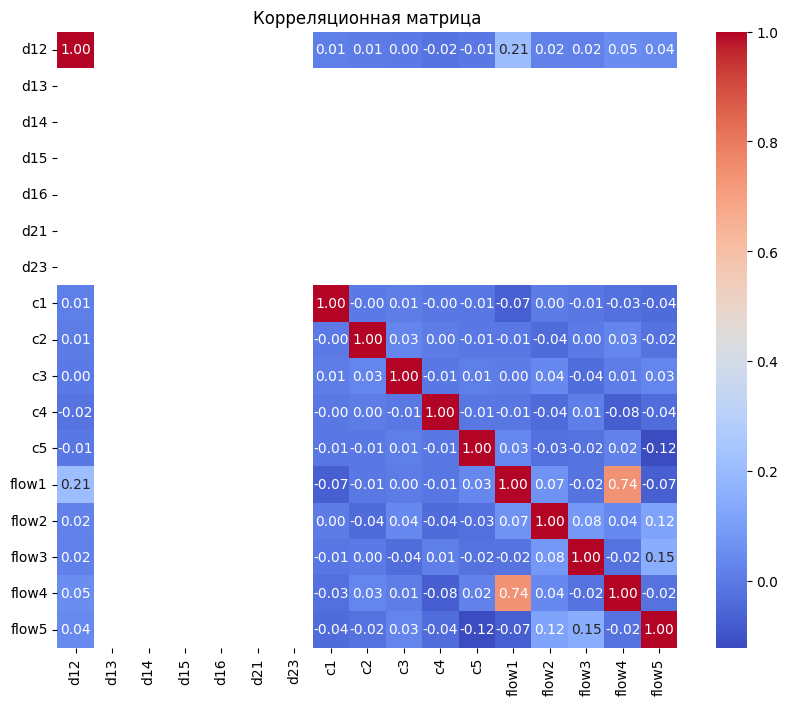

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['d12', 'd13', 'd14', 'd15', 'd16', 'd21', 'd23', 'c1', 'c2', 'c3', 'c4', 'c5', 'flow1', 'flow2', 'flow3', 'flow4', 'flow5']
corr_matrix = results_df[selected_columns].corr(method='spearman')

# Построение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

In [14]:
# import pickle
# import json
# model_name = "kan_400_pairs_2"

# with open(f"scalers/node_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(node_scaler, f)

# with open(f"scalers/edge_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(edge_scaler, f)

# with open(f"scalers/y_scaler_{model_name}.pkl", "wb") as f:
#     pickle.dump(y_scaler, f)

# torch.save(model.state_dict(), f"models/hetgat_model_{model_name}.pth")

# with open(f"indices/train_indices_{model_name}.json", "w") as f:
#     json.dump(train_indices, f)

# with open(f"indices/test_indices_{model_name}.json", "w") as f:
#     json.dump(test_indices, f)


In [15]:
# import pickle
# import json
# import torch

# model_name = "kan_v2"

# # Загрузка скейлеров
# with open(f"scalers/node_scaler_{model_name}.pkl", "rb") as f:
#     node_scaler = pickle.load(f)

# with open(f"scalers/edge_scaler_{model_name}.pkl", "rb") as f:
#     edge_scaler = pickle.load(f)

# with open(f"scalers/y_scaler_{model_name}.pkl", "rb") as f:
#     y_scaler = pickle.load(f)

# # Загрузка модели
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = HetGAT(24, 2).to(device)  # Создай экземпляр модели
# model.load_state_dict(torch.load(f"models/hetgat_model_{model_name}.pth"))
# model.eval()  # Перевод в режим оценки (если требуется)

# # Загрузка индексов
# with open(f"indices/train_indices_{model_name}.json", "r") as f:
#     train_indices = json.load(f)

# with open(f"indices/test_indices_{model_name}.json", "r") as f:
#     test_indices = json.load(f)

# # Теперь все данные загружены и готовы к использованию


In [16]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from utility import CustomHeteroGraphDataset
# from torch_geometric.loader import DataLoader
# from torch_geometric.data import Batch
# from utility import prepare_scalers
# from sklearn.preprocessing import MinMaxScaler

# src = "data/data_sioux.csv"

# df = pd.read_csv(src)
# indices = list(range(len(df)))
# train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# node_scaler, edge_scaler, y_scaler = prepare_scalers(src, train_indices, n_nodes=24, scaler_type=MinMaxScaler)

# train_dataset = CustomHeteroGraphDataset(src, train_indices, node_scaler, edge_scaler, y_scaler, 24)
# test_dataset = CustomHeteroGraphDataset(src, test_indices, node_scaler, edge_scaler, y_scaler, 24)

# # Создание DataLoader
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda batch: Batch.from_data_list(batch))
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda batch: Batch.from_data_list(batch))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


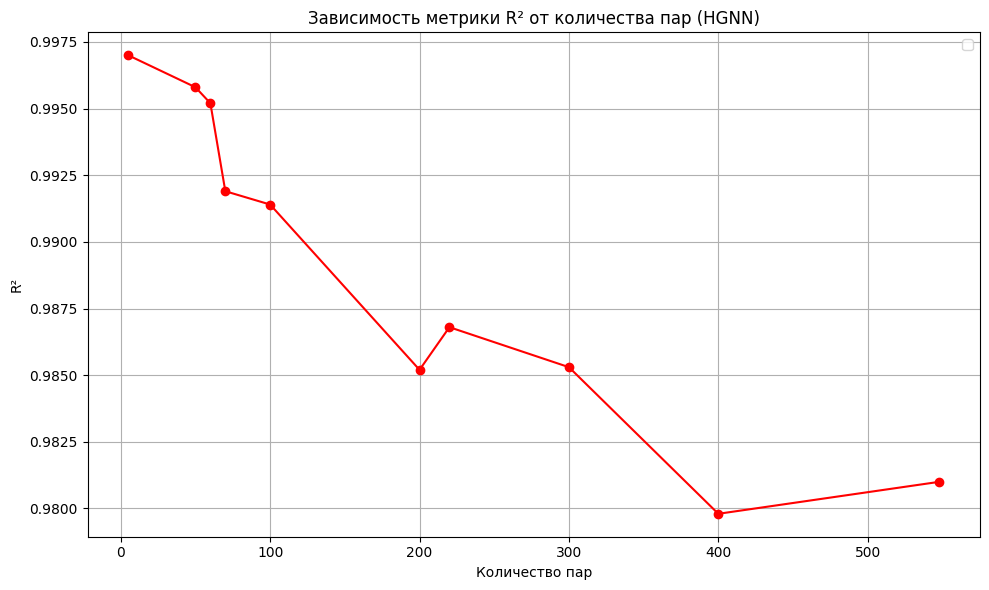

In [20]:
import matplotlib.pyplot as plt

# Данные
pairs = [5, 50, 60, 70, 100, 200, 220, 300, 400, 548]
r2_hgnn = [0.9970, 0.9958, 0.9952, 0.9919, 0.9914, 0.9852, 0.9868, 0.9853, 0.9798, 0.9810]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(pairs, r2_hgnn, marker='o', linestyle='-', color='red')

plt.title('Зависимость метрики R² от количества пар (HGNN)')
plt.xlabel('Количество пар')
plt.ylabel('R²')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


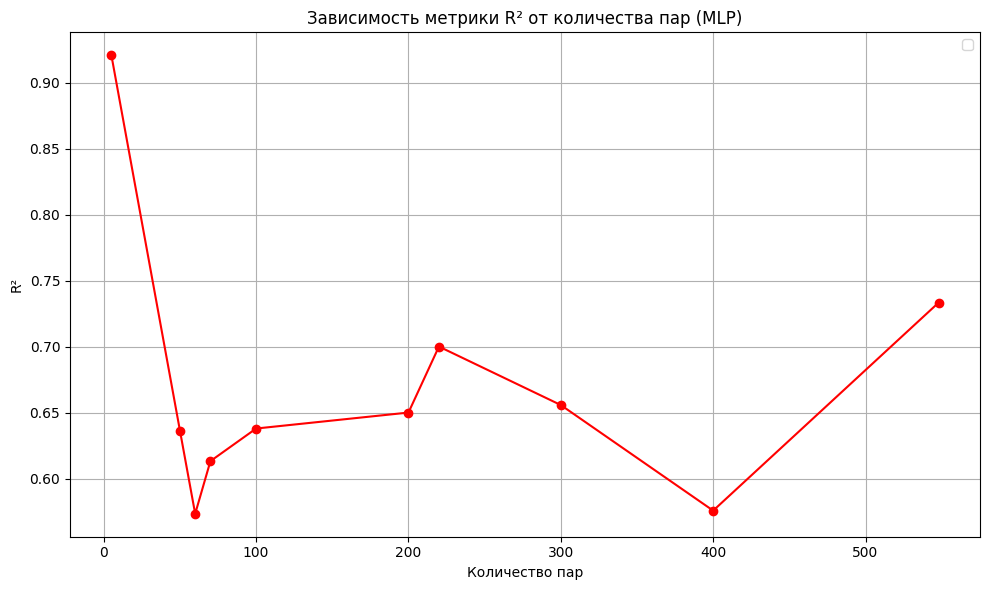

In [6]:
# Данные для модели MLP
r2_mlp = [0.9207, 0.6363, 0.5733, 0.6132, 0.6379, 0.65, 0.7, 0.6557, 0.5757, 0.7333]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(pairs, r2_mlp, marker='o', linestyle='-', color='red')

plt.title('Зависимость метрики R² от количества пар (MLP)')
plt.xlabel('Количество пар')
plt.ylabel('R²')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


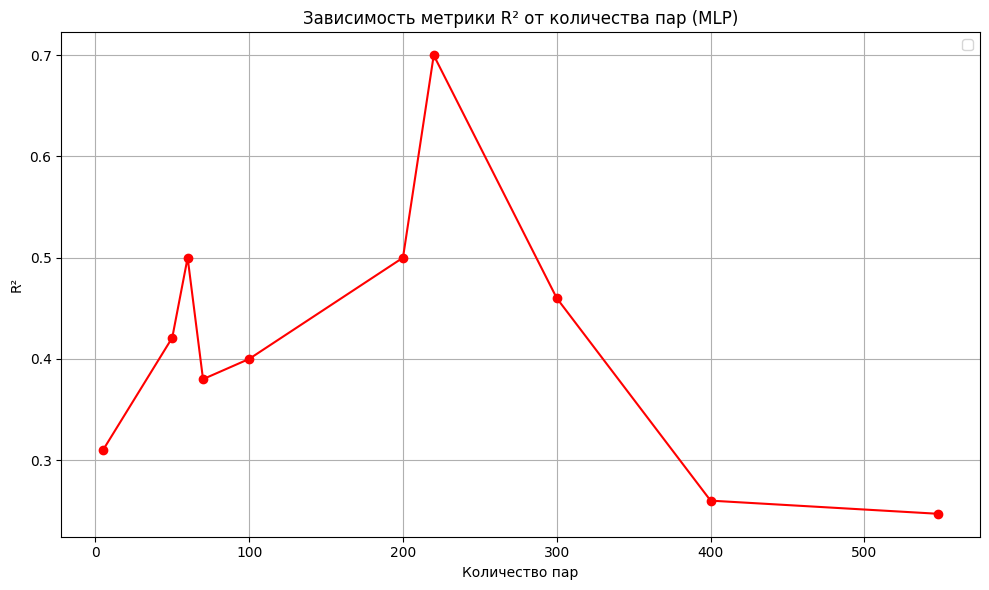

<Figure size 640x480 with 0 Axes>

In [19]:
# Данные для метрики MAPE
mape_hgnn = [0.021, 0.03, 0.04, 0.077, 0.04, 0.084, 0.0703, 0.0595, 0.052, 0.05]
mape_hgnn_kan = [0.016, 0.025, 0.037, 0.059, 0.038, 0.0718, 0.058, 0.0537, 0.047, 0.044]
mape_mlp = [0.31, 0.421, 0.5, 0.38, 0.4, 0.5, 0.7, 0.46, 0.26, 0.247]

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(pairs, mape_mlp, marker='o', linestyle='-', color='red')

plt.title('Зависимость метрики R² от количества пар (MLP)')
plt.xlabel('Количество пар')
plt.ylabel('R²')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# HGNN+KAN
# axs[1].plot(pairs, mape_hgnn_kan, marker='o', linestyle='-', color='green', label='HGNN+KAN')
# axs[1].set_title('Зависимость MAPE от количества пар (HGNN+KAN)')
# axs[1].set_ylabel('MAPE')
# axs[1].grid(True)
# axs[1].legend()

# # MLP
# axs[2].plot(pairs, mape_mlp, marker='o', linestyle='-', color='red', label='MLP')
# axs[2].set_title('Зависимость MAPE от количества пар (MLP)')
# axs[2].set_xlabel('Количество пар')
# axs[2].set_ylabel('MAPE')
# axs[2].grid(True)
# axs[2].legend()

plt.tight_layout()
plt.show()
